In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import scipy.special as special
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf 

from sklearn import preprocessing
from theano import shared
from matplotlib.offsetbox import AnchoredText

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [3]:
import sys, IPython, scipy, matplotlib, pandas, seaborn, patsy, platform, theano, sklearn, statsmodels
print("""This notebook was created using:
Python {}
IPython {}
PyMC3 {}
ArviZ {}
NumPy {}
SciPy {}
Pandas {}
Seaborn {}
Patsy {}
Matplotlib {}
Theano {}
Sklearn {}
Statsmodels {}\n""".format(sys.version[:5], 
                             IPython.__version__, 
                             pm.__version__, 
                             az.__version__, 
                             np.__version__, 
                             scipy.__version__, 
                             pandas.__version__, 
                             seaborn.__version__, 
                             patsy.__version__, 
                             matplotlib.__version__, 
                             theano.__version__, 
                             sklearn.__version__, 
                             statsmodels.api.__version__))

This notebook was created using:
Python 3.7.4
IPython 7.13.0
PyMC3 3.8
ArviZ 0.8.2
NumPy 1.18.2
SciPy 1.4.1
Pandas 1.0.3
Seaborn 0.10.0
Patsy 0.5.1
Matplotlib 3.2.1
Theano 1.0.4
Sklearn 0.22.2.post1
Statsmodels 0.11.1



# Chapter 10 Big Entropy and the Generalized Linear Model

First, the distribution with the biggest entropy is the widest and least informative distri- bution. Choosing the distribution with the largest entropy means spreading probability as evenly as possible, while still remaining consistent with anything we think we know about a process.

**Bayesian updating and maximum entropy**. Another kind of probability distribution, the posterior distribution deduced by Bayesian updating, is also a case of maximizing entropy. 

## 10.1. Maximum entropy

The distribution that can happen the most ways is also the distribution with the biggest information entropy. The distribution with the biggest entropy is the most conservative distribution that obeys its constraints.

### Code 10.1

In [4]:
d = {'A':[0, 0, 10, 0, 0], 
     'B':[0, 1, 8, 1, 0], 
     'C':[0, 2, 6, 2, 0], 
     'D':[1, 2, 4, 2, 1], 
     'E':[2, 2, 2, 2, 2]}
df = pd.DataFrame(data=d)
df

,A,B,C,D,E
0,0,0,0,1,2
1,0,1,2,2,2
2,10,8,6,4,2
3,0,1,2,2,2
4,0,0,0,1,2


### Code 10.2

In [5]:
df_norm = df/df.sum(0)
df_norm

,A,B,C,D,E
0,0.0,0.0,0.0,0.1,0.2
1,0.0,0.1,0.2,0.2,0.2
2,1.0,0.8,0.6,0.4,0.2
3,0.0,0.1,0.2,0.2,0.2
4,0.0,0.0,0.0,0.1,0.2


### Code 10.3

In [6]:
def entropy(x):
    y = []
    for i in x:
        if i == 0:
            y.append(0)
        else: 
            y.append(i*np.log(i))
    h = -sum(y)
    return h

In [7]:
H = df_norm.apply(entropy, axis=0)
H

A   -0.000000
B    0.639032
C    0.950271
D    1.470808
E    1.609438
dtype: float64

### Code 10.4

In [8]:
ways = [1, 90, 1260, 37800, 113400]
logwayspp = np.log(ways)/10

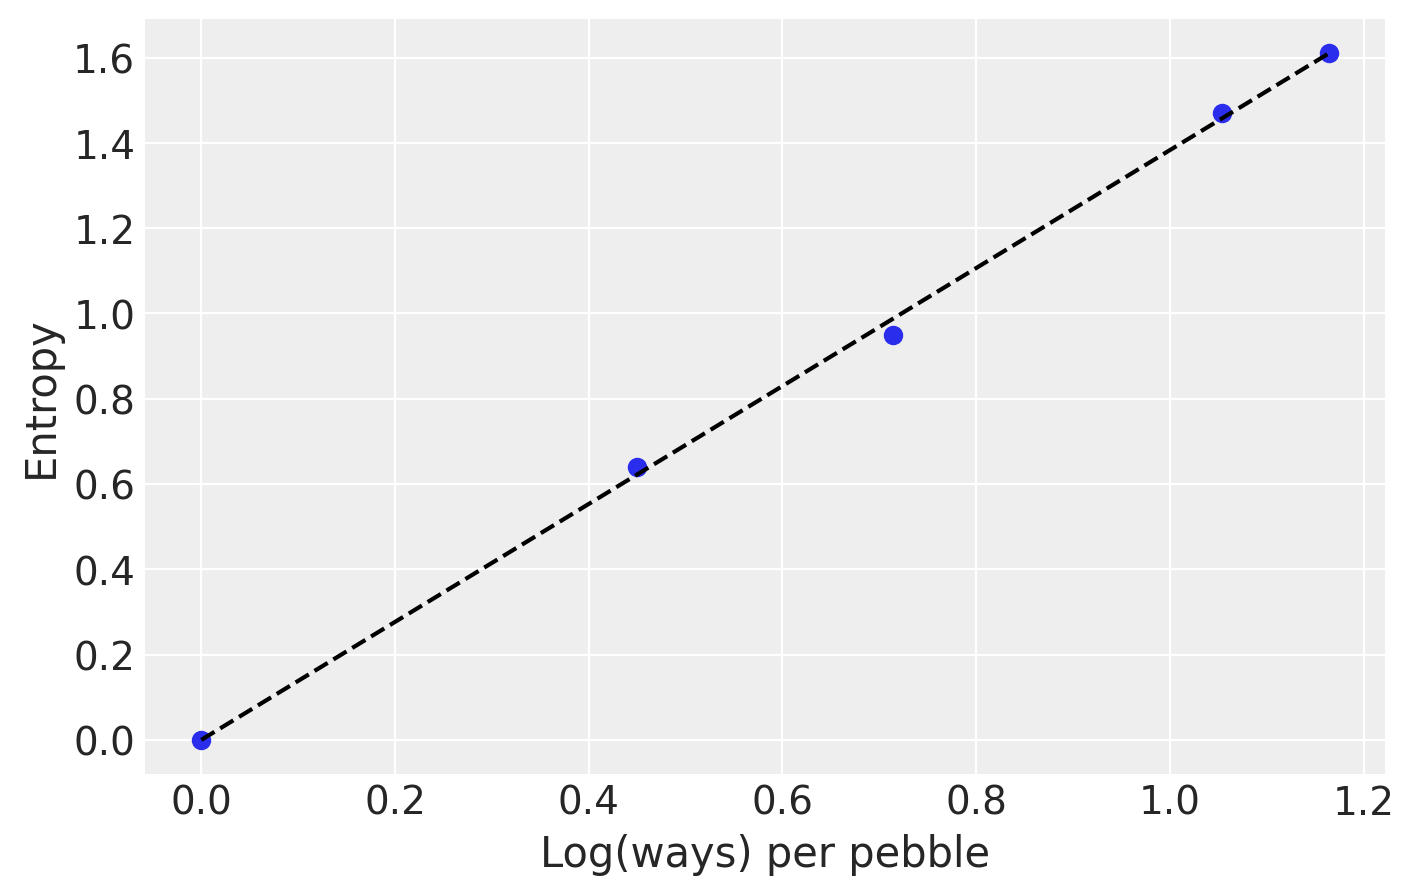

In [9]:
# plot results
fig = plt.figure(figsize=(8, 5))
plt.plot(logwayspp, H, 'o')
plt.plot([0.0, max(logwayspp)], [0.0, max(H)], '--k')
plt.ylabel('Entropy', fontsize=15)
plt.xlabel('Log(ways) per pebble', fontsize=15)
plt.show()

The distribution that can happen the greatest number of ways is the most plausible distribution. Call this distribution the **maximum entropy distribution**.

### 10.1.1. Gaussian

The take-home lesson from all of this is that, if all we are willing to assume about a collection of measurements is that they have a finite variance, then the Gaussian distribution represents the most conservative probability distribution to assign to those measurements. But very often we are comfortable assuming something more. And in those cases, provided our assumptions are good ones, the principle of maximum entropy leads to distributions other than the Gaussian.

### 10.1.2. Binomial

### Code 10.5

In [10]:
# Build list of the candidate distributions.
p = [[1/4, 1/4, 1/4, 1/4],
     [2/6, 1/6, 1/6, 2/6],
     [1/6, 2/6, 2/6, 1/6],
     [1/8, 4/8, 2/8, 1/8]]

# Compute expected value of each. The sum of the multiplied entries is just a dot product.
p_ev = [np.dot(i, [0, 1, 1, 2]) for i in p]
p_ev

[1.0, 1.0, 1.0, 1.0]

### Code 10.6

In [11]:
# Compute entropy of each distribution
p_ent = [entropy(i) for i in p]
p_ent

[1.3862943611198906,
 1.3296613488547582,
 1.3296613488547582,
 1.2130075659799042]

### Code 10.7

In [12]:
p = 0.7
A = [(1-p)**2, p*(1-p), (1-p)*p, p**2]
A

[0.09000000000000002,
 0.21000000000000002,
 0.21000000000000002,
 0.48999999999999994]

### Code 10.8

In [13]:
entropy(A)

1.221728604109787

### Code 10.9

In [14]:
def sim_p(G=1.4):
    x123 = np.random.uniform(size=3)
    x4 = (G * np.sum(x123) - x123[1] - x123[2]) / (2 - G)
    x1234 = np.concatenate((x123, [x4]))
    z = np.sum(x1234)
    p = x1234 / z
    return - np.sum(p * np.log(p)), p

### Code 10.10 and Code 10.11

In [15]:
H = []
p = np.zeros((10**5, 4))
for rep in range(10**5):
    h, p_ = sim_p()
    H.append(h)
    p[rep] = p_

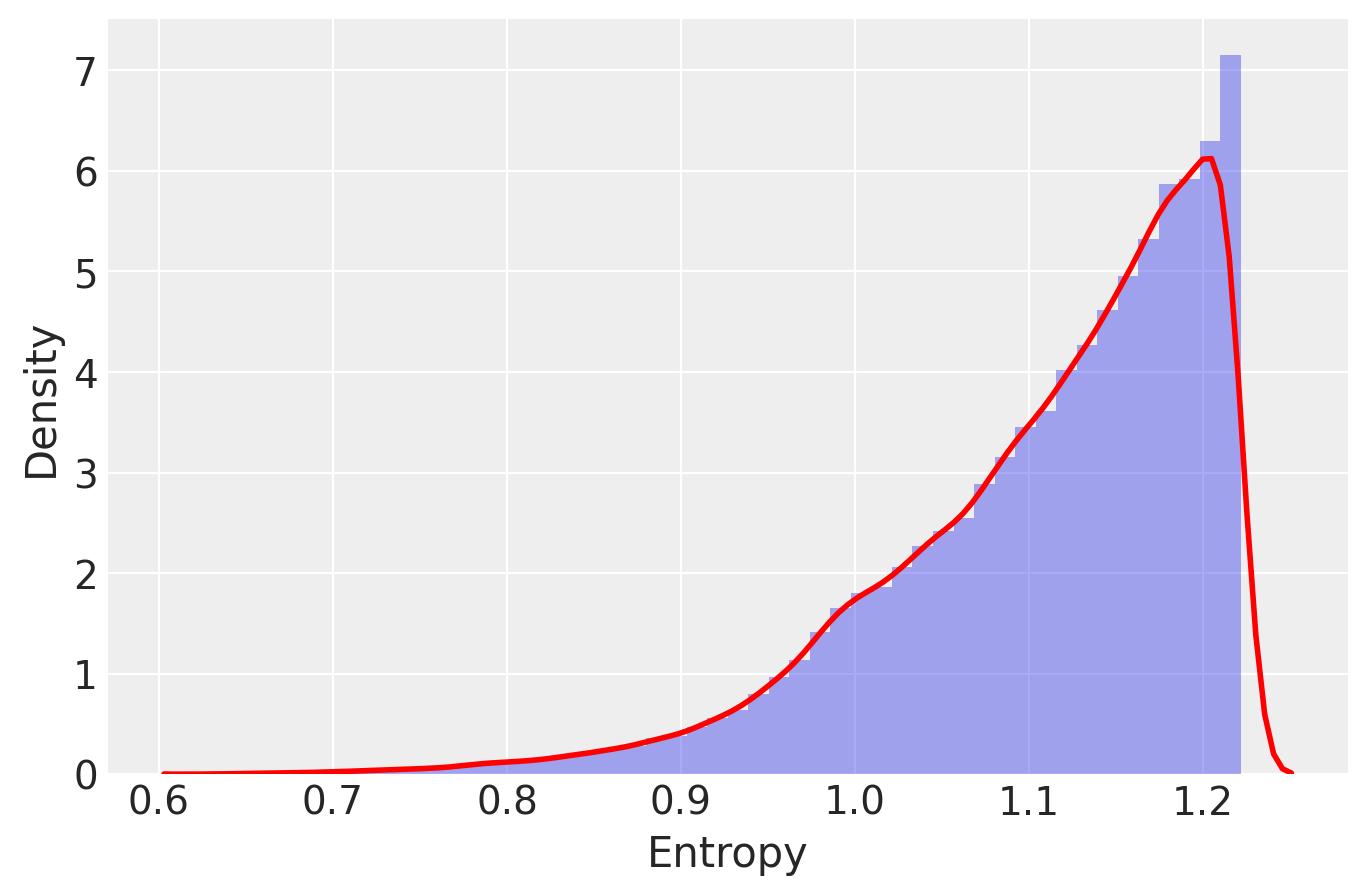

In [16]:
# plot figure
fig = plt.figure(figsize=(8, 5))
sns.distplot(H, hist = True, kde = True, kde_kws = {'linewidth': 2, 'color': 'r'})
plt.xlabel('Entropy', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.show()

### Code 10.12

In [17]:
np.max(H)

1.2217259308018917

### Code 10.13

In [18]:
p[np.argmax(H)]

array([0.09038638, 0.21006718, 0.20916005, 0.49038638])

## 10.2. Generalizedl inear models

The most common distributions used in statistical modeling are members of a family known as the **exponential family**.

**exponential distribution** is constrained to be zero or positive. It is a fundamental distribution of distance and duration, kinds of measurements that represent displacement from some point of reference, either in time or space.

**gamma distribution** is also constrained to be zero or positive. It too is a fundamental distribution of distance and duration. But unlike the exponential distribution, the gamma distribution can have a peak above zero. 

**Poisson distribution** is a count distribution like the binomial. It is actually a special case of the binomial, mathematically.

**logit link** maps a parameter that is defined as a probability mass, and therefore constrained to lie between zero and one, onto a linear model that can take on any real value. This link is extremely common when working with binomial GLMs. 

**log link** maps a parameter that is defined over only positive real values onto a linear model. 

Really all you have to remember is to only compare models that all use the same type of likelihood. Of course it is possible to compare models that use different likelihoods, just not with information criteria. 

## 10.3. Maximum entropy priors

GLMs are easy to use with conventional weakly informative priors of the sort you’ve been using up to this point in the book. Such priors are nice, because they allow the data to dominate inference while also taming some of the pathologies of unconstrained estimation.

### Referece

[pymc-devs: Rethinking_1 Chp09](https://github.com/pymc-devs/resources/blob/master/Rethinking/Chp_09.ipynbb)